# **Unitary machine learning for planar datasets**

To demonstrate how `neurophox` models can be used for small machine learning problems, we can make some small binary classification models in Tensorflow 2 using the `RM` class from the `neurophox.tensorflow` module. We solve multiple simple binary classification problems provieded by the `sklearn` framework (note, you will need to install `sklearn` for this notebook!): `circles`, `moons`, `gaussian_quantiles`, `blobs`.

In [1]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Lambda

# neurophox imports
from neurophox.tensorflow import RM
from neurophox.ml import cnorm, cnormsq

# other python / plotting imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as pbar
from collections import namedtuple

# comment out the below two lines if you have trouble getting the plots to work
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Charter']})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact

from sklearn.datasets import make_circles, make_moons, make_blobs, make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
def add_bias(x, p=10):
    abs_sq_term = np.sum(x**2, axis=1)[:, np.newaxis]
    abs_sq_term[abs_sq_term > p] = p  # avoid nan in case it exists
    normalized_bias_term = np.sqrt(p - abs_sq_term)
    return np.hstack([x, normalized_bias_term])

## Data and plotting setup

All planar data is represented in terms of 3 values: the first two values are the $x, y$ coordinates and the final value is the requisite magnitude $\sqrt{P - x^2 - y^2}$  given the total power set by the `add_bias` method, $P = 10$. Therefore, we take the appropriate `sklearn` datasets and transform them using `add_bias` to get our test and train sets. We then do an 80/20 train/test split for all datasets for our training and evaluation metrics (though for our final plots, we actually look at the classification over the entire dataset).

In [3]:
# X has shape (n_features, n_samples), y has true labels, (n_features, n_samples)
Dataset = namedtuple('Dataset', ['X', 'y'])

def get_planar_dataset_with_circular_bias(dataset_name, test_size=.2):
    if dataset_name == 'moons':
        X, y = make_moons(noise=0.3, random_state=0, n_samples=250)
    elif dataset_name == 'circle':
        X, y = make_circles(noise=0.2, factor=0.5, random_state=1, n_samples=250)
    elif dataset_name == 'blobs':
        X, y = make_blobs(random_state=5, n_features=2,
                          centers=[(-0.4, -0.4), (0.25, 0.3)],
                          cluster_std=0.5, n_samples=250)
    elif dataset_name == 'ring':
        X, y = make_gaussian_quantiles(n_features=2, n_classes=3, n_samples=500, cov=0.4)
        y[y==2] = 0
    y = to_categorical(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    X_train_f = add_bias(X_train).astype(np.complex64)
    X_test_f = add_bias(X_test).astype(np.complex64)
    y_train_f = y_train.astype(np.complex64)
    y_test_f = y_test.astype(np.complex64)
    
    return Dataset(X, y), Dataset(X_train_f, y_train_f), Dataset(X_test_f, y_test_f)

moons, moons_train, moons_test = get_planar_dataset_with_circular_bias('moons')
circle, circle_train, circle_test = get_planar_dataset_with_circular_bias('circle')
blobs, blobs_train, blobs_test = get_planar_dataset_with_circular_bias('blobs')
ring, ring_train, ring_test = get_planar_dataset_with_circular_bias('ring')

In [4]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

light_rdbu = cmap_map(lambda x: 0.5 * x + 0.5, plt.cm.RdBu)
dark_bwr = cmap_map(lambda x: 0.75 * x, plt.cm.bwr)

def plot_planar_boundary(plt, dataset, model, ax=None, grid_points=50):   
    if ax is None:
        ax = plt.axes()
    x_min, y_min = -2.5, -2.5
    x_max, y_max = 2.5, 2.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_points), np.linspace(x_min, x_max, grid_points))

    # Predict the function value for the whole grid
    inputs = []
    for x, y in zip(xx.flatten(), yy.flatten()):
        inputs.append([x, y])
    inputs = add_bias(np.asarray(inputs))

    Y_hat = model.predict(inputs)
    Y_hat = [yhat[0] for yhat in Y_hat]
    Z = np.array(Y_hat)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plot_handle = ax.contourf(xx, yy, Z, 50, cmap=light_rdbu, linewidths=0)
    cbar = plt.colorbar(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], mappable=plot_handle, ax=ax)
    cbar.set_clim((0, 1))

    points_x = dataset.X.T[0,:]
    points_y = dataset.X.T[1,:]
    labels = np.array([0 if yi[0] > yi[1] else 1 for yi in np.abs(dataset.y)]).flatten()

    ax.set_ylabel(r'$x_2$', fontsize=16)
    ax.set_xlabel(r'$x_1$', fontsize=16)

    ax.scatter(points_x, points_y, c=labels, edgecolors='black', linewidths=0.1, s=10, cmap=dark_bwr)

## Circles model

In [5]:
circles_model = Sequential([
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    Activation(cnormsq),
    Lambda(lambda x: tf.math.real(x[:, :2])), # get first 2 output ports (we already know it is real from the activation),
    Activation('softmax')
])

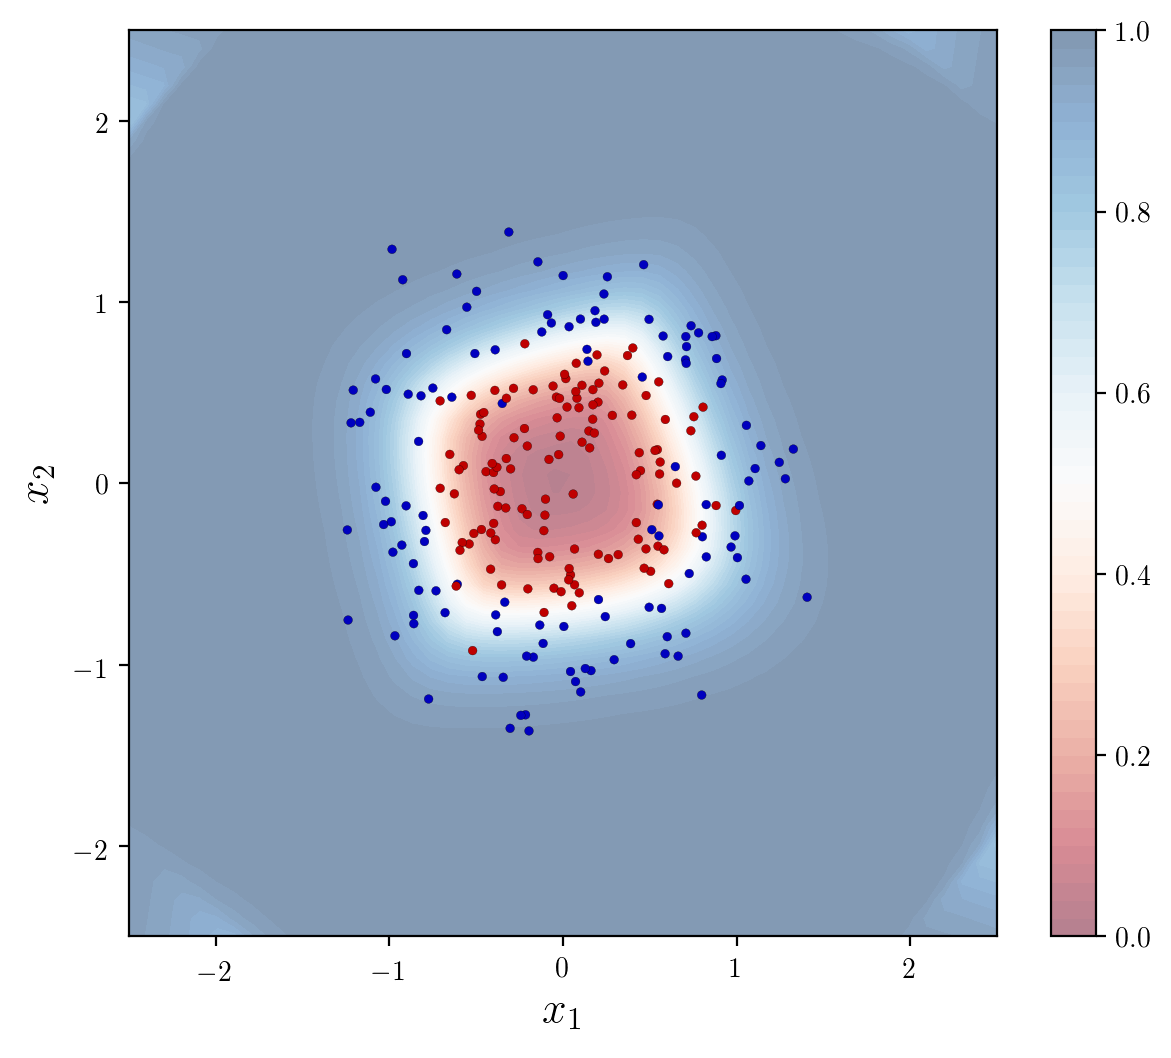

In [6]:
num_iterations = 3000

circles_test_losses = []
circles_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0025))
iterator = pbar(range(num_iterations))
for iteration in iterator:
    test_loss = circles_model.evaluate(circle_test.X, circle_test.y, verbose=0)
    circles_model.train_on_batch(circle_train.X, circle_train.y)
    circles_test_losses.append(test_loss)
    iterator.set_description(f"𝓛: {test_loss:.5f}")
plt.figure(figsize=(7, 6), dpi=200)
plot_planar_boundary(plt, circle, circles_model)

## Moons model

In [7]:
moons_model = Sequential([
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    Activation(cnormsq),
    Lambda(lambda x: tf.math.real(x[:, :2])), # get first 2 output ports (we already know it is real from the activation),
    Activation('softmax')
])

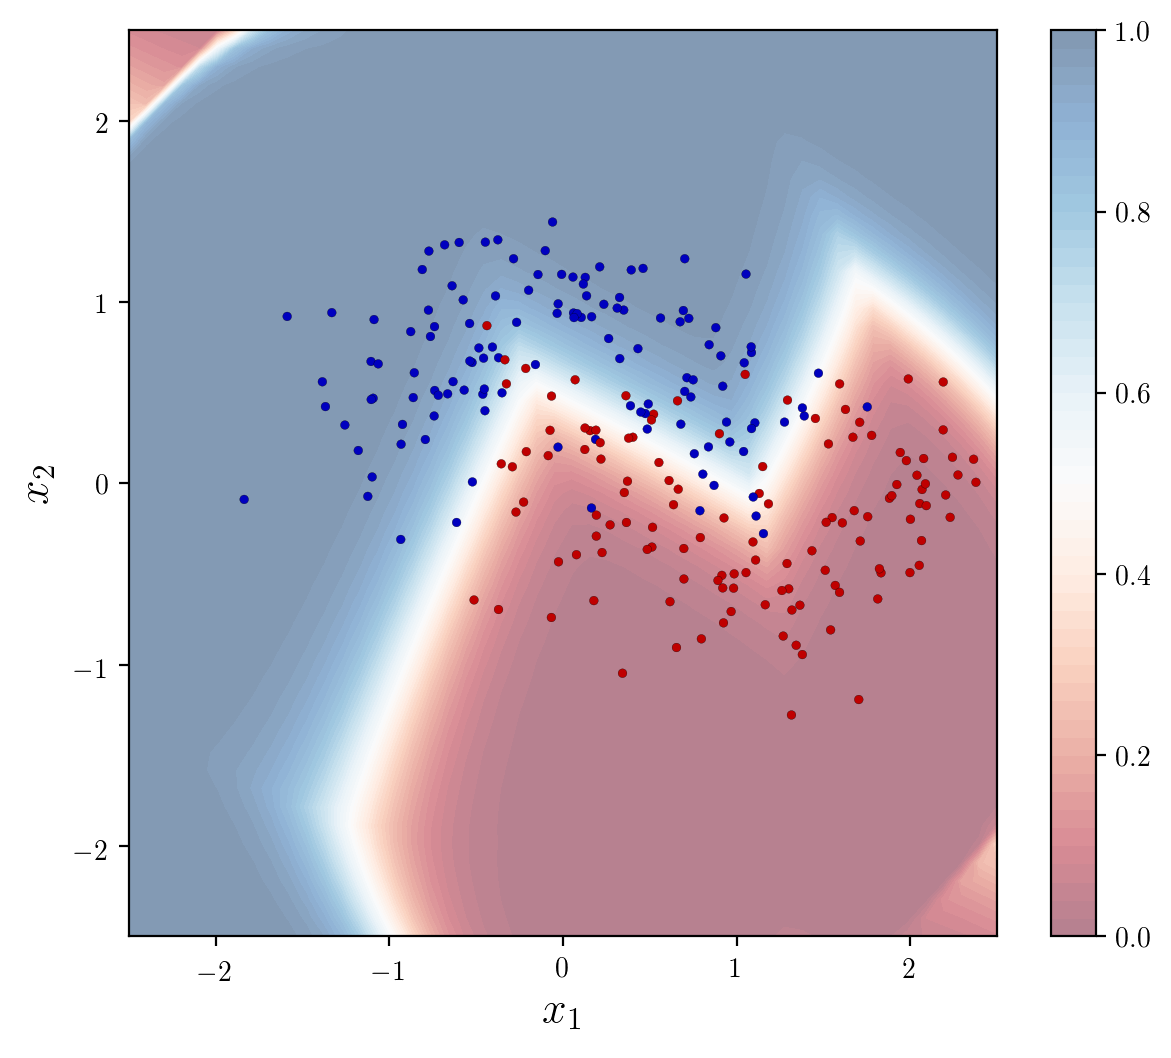

In [8]:
num_iterations = 4000

moons_test_losses = []
moons_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0025))
iterator = pbar(range(num_iterations))
for iteration in iterator:
    test_loss = moons_model.evaluate(moons_test.X, moons_test.y, verbose=0)
    moons_model.train_on_batch(moons_train.X, moons_train.y)
    moons_test_losses.append(test_loss)
    iterator.set_description(f"𝓛: {test_loss:.5f}")
plt.figure(figsize=(7, 6), dpi=200)
plot_planar_boundary(plt, moons, moons_model)

## Blobs model

In [9]:
blobs_model = Sequential([
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    Activation(cnormsq),
    Lambda(lambda x: tf.math.real(x[:, :2])), # get first 2 output ports (we already know it is real from the activation),
    Activation('softmax')
])

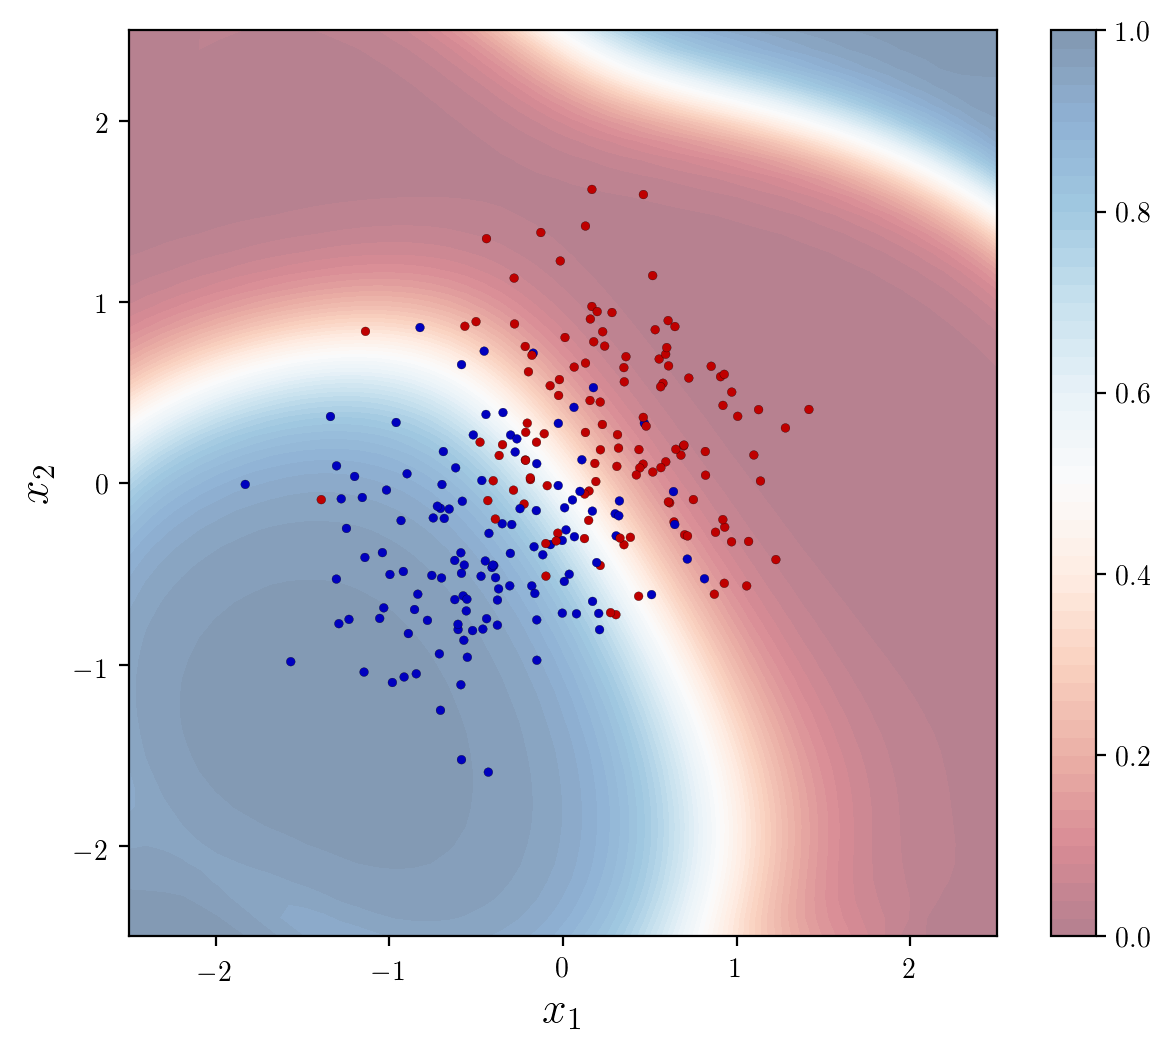

In [10]:
num_iterations = 3000

blobs_test_losses = []
blobs_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0025))
iterator = pbar(range(num_iterations))
for iteration in iterator:
    test_loss = blobs_model.evaluate(blobs_test.X, blobs_test.y, verbose=0)
    blobs_model.train_on_batch(blobs_train.X, blobs_train.y)
    blobs_test_losses.append(test_loss)
    iterator.set_description(f"𝓛: {test_loss:.5f}")
plt.figure(figsize=(7, 6), dpi=200)
plot_planar_boundary(plt, blobs, blobs_model)

## Rings model

Note: the ring is found most of the time, but there is about a small percent chance it may fail (final loss should initially taper off near 0.6 and then reach 0.35 or so if it works, but it stays near 0.6 if it fails). 

In [15]:
ring_model = Sequential([
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    RM(3, activation=Activation(cnorm)),
    Activation(cnormsq),
    Lambda(lambda x: tf.math.real(x[:, :2])), # get first 2 output ports (we already know it is real from the activation),
    Activation('softmax')
])

In [16]:
num_iterations = 5000

ring_test_losses = []
ring_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0025))
iterator = pbar(range(num_iterations))
for iteration in iterator:
    test_loss = ring_model.evaluate(ring_test.X, ring_test.y, verbose=0)
    ring_model.train_on_batch(ring_train.X, ring_train.y)
    ring_test_losses.append(test_loss)
    iterator.set_description(f"𝓛: {test_loss:.5f}")

## Result Comparison

Comparing the performances and optimization curves for all experiments above.

<Figure size 1200x800 with 0 Axes>

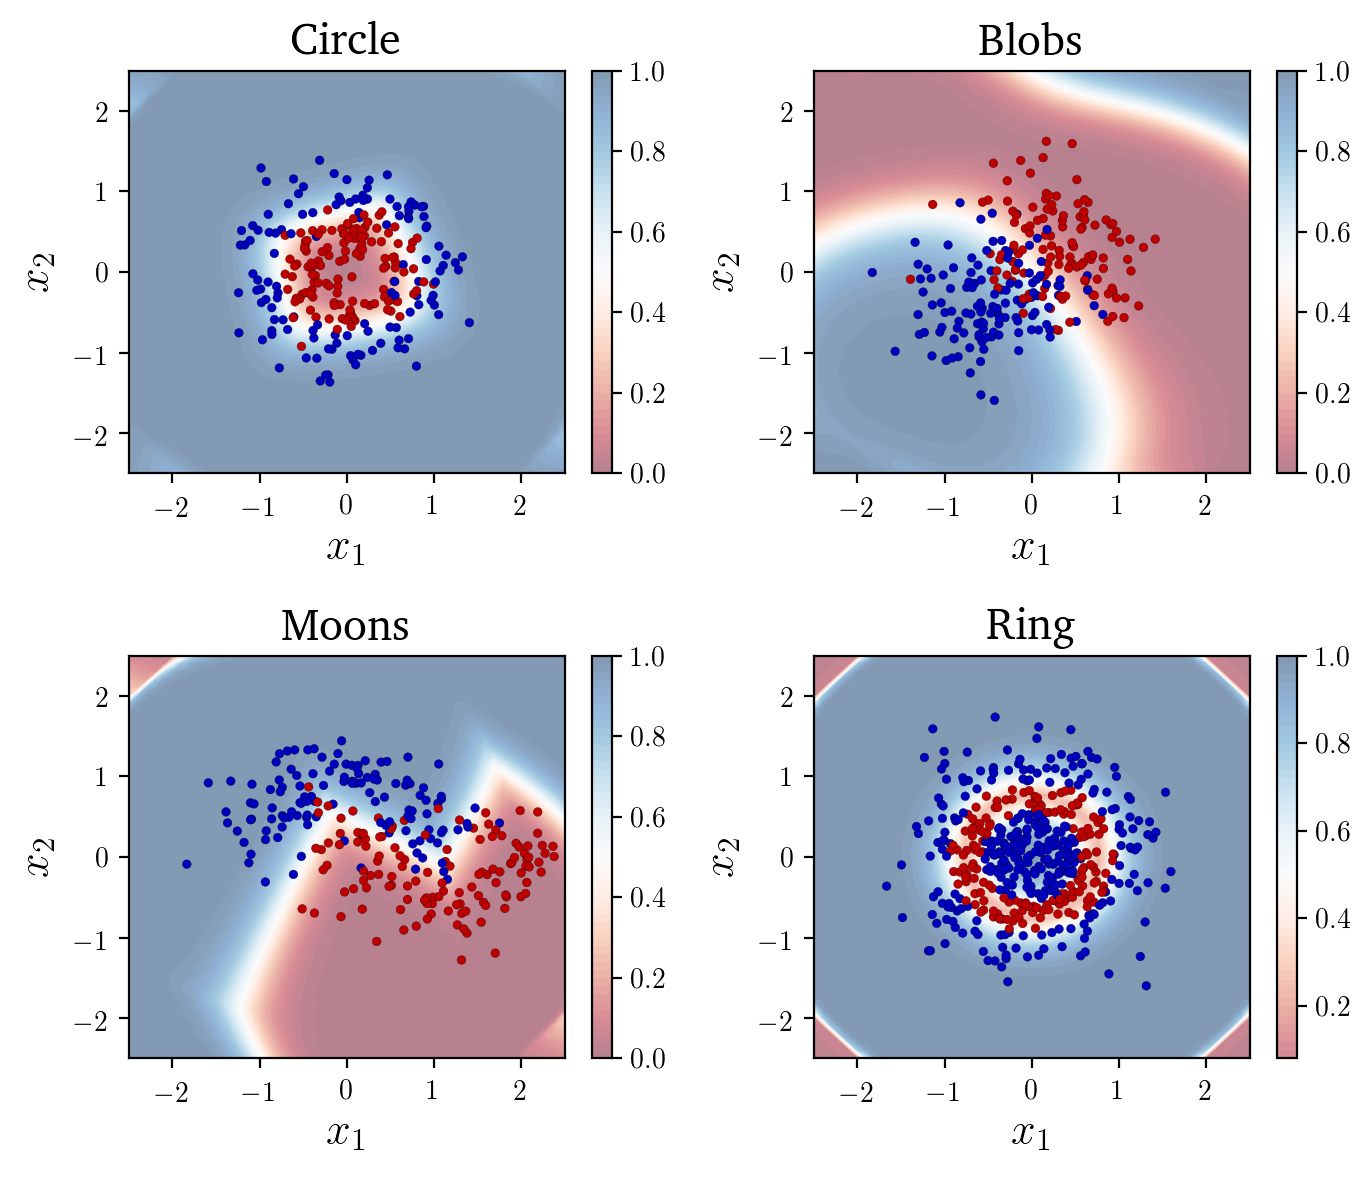

In [18]:
plt.figure(dpi=200)
fig, ax = plt.subplots(2, 2, figsize=(7, 6), dpi=200)
plot_planar_boundary(plt, circle, circles_model, ax=ax[0, 0])
ax[0, 0].set_title('Circle', fontsize=16)
plot_planar_boundary(plt, moons, moons_model, ax=ax[1, 0])
ax[1, 0].set_title('Moons', fontsize=16)
plot_planar_boundary(plt, blobs, blobs_model, ax=ax[0, 1])
ax[0, 1].set_title('Blobs', fontsize=16)
plot_planar_boundary(plt, ring, ring_model, ax=ax[1, 1])
ax[1, 1].set_title('Ring', fontsize=16)
plt.tight_layout()
# ax[0, 0].text(-0.3, 1.05, r'(\textbf{a})', transform=ax[0, 0].transAxes, size=20)
# plt.savefig('../data/figures/pnn_planar.pdf', bbox_inches='tight', pad_inches=0.01)

Text(0.5,1,'Planar Dataset Convergence')

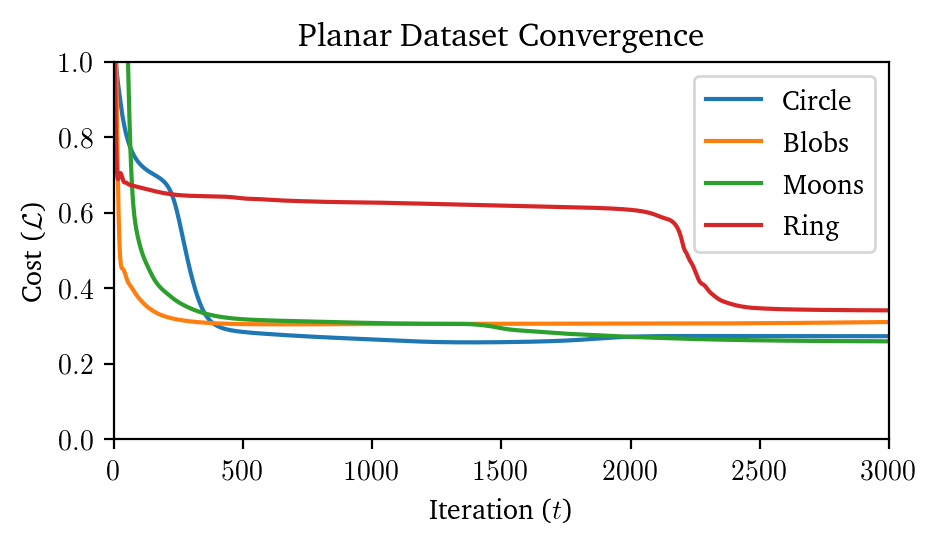

In [21]:
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.figure(dpi=200, figsize=(5, 2.5))
plt.plot(circles_test_losses)
plt.plot(blobs_test_losses)
plt.plot(moons_test_losses)
plt.plot(ring_test_losses)
plt.xlim((0, 3000))
plt.ylim((0, 1))
# plt.yticks([0.1, 0.2, 0.3, 0.4, 0.6, 1], [0.1, 0.2, 0.3, 0.4, 0.6, 1])
# plt.yscale('log')
plt.xlabel('Iteration ($t$)')
plt.ylabel(r'Cost ($\mathcal{L}$)')
plt.legend(['Circle', 'Blobs', 'Moons', 'Ring'])
plt.title('Planar Dataset Convergence')